In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
from math import log, ceil
from random import randint
import functools

---

In [4]:
class GeneticAlgo:

    def __init__(self, a,b, functionOptions, 
                 populationOpts, operatorOpts, tournamentOpts,
                 freezeLimit = 6, precision = 10**(-6)):
        
        self.a, self.b = a, b
        self.func, self.funcVariables, self.funcFitness = functionOptions
        self.popNumber, self.popSize = populationOpts        
        self.mutationChance, self.crossChance = operatorOpts
        self.tournamentMembersNumber = tournamentOpts
        self.freezeLimit = freezeLimit
        self.precision = precision
        
        self.__initValues()
    
        self.infoData = {
            "OffspringNUmber": 0,
            "CurrentFittest": []
        }
        

# Initializaton functions
#----------------------------------------------------------------------

    def __initValues(self):
        self.offspringNumber = 0
        self.freezeNumber = 0
        
        self.length = self.__initLength()
        self.population = self.__initPopulation()
        self.fittest = self.__initFittest()
        self.bits = self.__initMaxBits()
        self.realPrecision = self.__initRealPrecision()
        self.variablesNumber = len(self.funcVariables)

    def __initLength(self): return self.b - self.a
    
    def __initPopulation(self): 
        zipElems = zip( *[ np.random.randint(self.a, self.b + 1, self.popSize) for variable in self.funcVariables ])
        listElems = [ list(elem) for elem in zipElems]
        return np.array(listElems)
    
    def __initFittest(self): return np.random.randint(self.a, self.b, len(self.funcVariables)) 
    
    def __initMaxBits(self): return ceil(log(self.length/self.precision, 2))   
    
    def __initRealPrecision(self):
        
        maxBinaryinBaseTen = 2**self.bits / self.length
        
        return 1 / maxBinaryinBaseTen
    
    
# Main functions
#----------------------------------------------------------------------

    def solve(self, displayData = False):
        
        while (self.freezeNumber < self.freezeLimit):
            self.population = self.__offspring()
            
            if (not self.__newFitElemExist()):
                self.freezeNumber+=1
            self.offspringNumber+=1
            
            if displayData: self.__displayData()
            
        return self.fittest, self.__funcSubs(self.fittest)
    
        
    def __offspring(self):
            
        children = []

        while len(children) < self.popSize:

            selected = self.__selectMultiple(2)     
            mutated = self.__execute(self.__mutateMultiple, self.mutationChance, selected)
            crossed = self.__execute(self.__crossMultiple, self.crossChance, mutated)

            children.extend(self.__listToNumber(crossed))

        return np.array(children)       
        

    def __select(self):
    
        indexes = np.random.choice(self.popSize, self.tournamentMembersNumber)
        
        competitors = self.population[indexes]
        
        winner = self.__tournament(competitors)
        
        return self.__toBinaryElem(winner)

    
    def __mutate(self, binary):
        
        index = np.random.randint(1, self.bits)
        
        binary[index] = self.__bitFlip(binary[index])
        
        return binary


    def __cross(self, binaries):
        
        index = randint(1, self.bits)
        
        return self.__merge(binaries, index)  
    
                
    def __newFitElemExist(self): 
        
        sortedElements = self.__fitnessSort(self.population)
        
        currentFittest = sortedElements[0]
        
        self.infoData["CurrentFittest"].append(self.__funcSubs(currentFittest))
        
        if self.__isFittest(currentFittest, self.fittest):
            self.fittest = currentFittest
            return True
        
        return False
        
        
    def __isFittest(self, elem1, elem2): return self.funcFitness(self.__funcSubs(elem1), self.__funcSubs(elem2))
    
    def __getFittest(self, elem1, elem2): return elem1 if self.__isFittest(elem1, elem2) else elem2   
        
    
#----------------------------------------------------------------------    


    def __tournament(self, competitors): 
        
        winner = competitors[0]
        
        for idx in range(1, self.tournamentMembersNumber):
            winner = self.__getFittest(winner, competitors[idx])
            
        return winner
    
    
    def __merge(self, elems, index):   
        elem1, elem2 = elems    
    
        if index == 0: index+=1

        for idx in range(index, self.bits):
            elem1[idx], elem2[idx] = elem2[idx], \
                                     elem1[idx]
        return elem1, elem2
    
        
    def __evaluate(self): return [ (elem, self.__funcSubs(elem)) for elem in self.population ]
                       
                      
    def __displayData(self):
        print("\n -------- ")
        #print(f'population - {self.population}')
        print(f'fittest = elem: {self.fittest}; func(elem): {self.__funcSubs(self.fittest)})')
        print(f'freeze number - {self.freezeNumber}')
        print(f'offspring number - {self.offspringNumber}')
        #print(self.__evaluate())
                      
    
# Helper functions
#----------------------------------------------------------------------
    def __execute(self, func, probability, value):
        return func(value) if (randint(1, 100) / 100) < probability else value
    
    def __selectMultiple(self, n): 
        return [self.__select() for i in range(n)]
    
    def __mutateMultiple(self, elems): 
        return [ self.__mutateElem(elem) for elem in elems ]
    
    def __crossMultiple(self, elems):
        return zip(*[ self.__cross(elem) for elem in zip(*elems) ])
    
    def __toBinaryElem(self, elem): 
        return [ self.__toBinary(number) for number in elem ]
    
    def __toNumberElem(self, elem):
        return [ self.__toNumber(binary) for binary in elem ]
    
    def __mutateElem(self, elem): 
        return [ self.__mutate(binary) for binary in elem ]
                      
    def __funcSubs(self, values):        
        return float(self.func.subs(dict(zip(self.funcVariables, values))))
                      
    def __fitnessSort(self, elements):
        return sorted(elements, key = lambda elem: abs(self.__funcSubs(elem)))
    

# Utility functions
#----------------------------------------------------------------------
        
    
    def __toBinary(self, number): 
        
        baseTen = (number - self.a) * 2**self.bits / self.length
        
        return list("{0:b}".format(int(baseTen)).zfill(self.bits))
        
        
    def __toNumber(self, bitList): 
                
        baseTwo = sum([ int(bitList[i]) * (2**(self.bits - 1 - i)) for i in range(self.bits)])
        
        return self.a + baseTwo * (self.length / 2**self.bits)


    def __listToNumber(self, elemList): 
        return [ self.__toNumberElem(elem) for elem in elemList ]
                      
    
    def __bitFlip(self, bit): 
        return '1' if bit == '0' else '0'

---

## Initialization

In [5]:
variables = x1, x2 = symbols("x1 x2")

In [6]:
def fitnessFunc(a,b): return abs(a) < abs(b)

In [7]:
a, b = -10, 10
func = x1*sin(10*pi*x2) + 1 

functionOpts = func, variables, fitnessFunc
populationOpts = populationNumber, populationSize = 5, 100
operatorOpts = mutation, crossover = 0.2, 0.8
tournamentMembersOpts = 3
freezeLimit = 6
precision = 10**-6

## Calculation

In [8]:
ga = GeneticAlgo(a,b, functionOpts, populationOpts, operatorOpts, tournamentMembersOpts, freezeLimit, precision)

In [9]:
ga.solve()

(array([-1.50015354, -2.9767704 ]), -0.00016018965460878128)

### Fitness function X Iteration

In [129]:
ga = GeneticAlgo(a,b, functionOpts, (5, 100), (0.2, 0.8), 3, freezeLimit, precision)
ga.solve()

(array([ 7.99996853, -6.00398481]), 0.001126003835129014)

Text(0, 0.5, 'Current fittest')

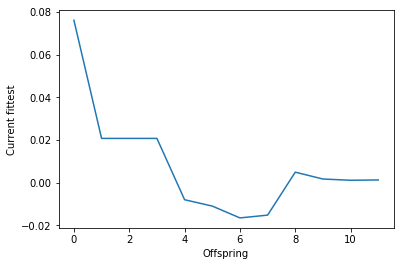

In [130]:
fittest = []
    
offspring = np.arange(0, ga.offspringNumber)
fittest.extend(ga.infoData["CurrentFittest"])

plt.plot(offspring, fittest)
plt.xlabel('Offspring')
plt.ylabel('Current fittest')

### Iteration with solution X Tournament members

In [132]:
solutionInOffspring = []
tournamentMembers = []

for i in np.arange(2, 12, 1):
    ga = GeneticAlgo(a,b, functionOpts, (5, 250), (0.2, 0.8), i, freezeLimit, precision)
    ga.solve()
    
    tournamentMembers.append(i)
    solutionInOffspring.append(ga.offspringNumber)

Text(0, 0.5, 'Offspring')

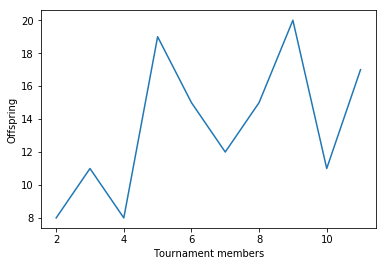

In [133]:
plt.plot(tournamentMembers, solutionInOffspring)
plt.xlabel('Tournament members')
plt.ylabel('Offspring')

---

---